In [1]:
import copy
import adcc
import gator
import matplotlib.pyplot as plt
import multipsi as mtp
import numpy as np
import veloxchem as vlx
from matplotlib import gridspec
from scipy.interpolate import interp1d
import py3Dmol as p3d

# au to eV conversion factor
au2ev = 27.211386

/Users/golo.dusanka/miniconda3/envs/echem/lib/python3.12/site-packages/adcc/misc.py:26: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [2]:
# These will be removed and included through VeloxChem

def lorentzian(x, y, xmin, xmax, xstep, gamma):
    """
    Lorentzian broadening function

    Call: xi,yi = lorentzian(energies, intensities, start energy,
                                    end energy, energy step, gamma)
    """
    xi = np.arange(xmin, xmax, xstep)
    yi = np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)):
            yi[i] = (
                yi[i]
                + y[k] * gamma / ((xi[i] - x[k]) ** 2 + (gamma / 2.0) ** 2) / np.pi
            )
    return xi, yi

class MockTask:
    def __init__(self, mol, basis, comm, ostream):
        self.molecule = mol
        self.ao_basis = basis
        self.mpi_comm = comm
        self.ostream = ostream

In [3]:
water_xyz = """3

O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Create veloxchem mol and basis objects
molecule = vlx.Molecule.read_xyz_string(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

In [4]:
viewer = p3d.view(width=300, height=200)
viewer.addModel(water_xyz, 'xyz')
viewer.setViewStyle({"style": "outline", "width": 0.05})
viewer.setStyle({"stick":{},"sphere": {"scale":0.25}})
viewer.rotate(-90,'x')
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [5]:
# Perform SCF calculation
scf_gs = vlx.ScfRestrictedDriver()
scf_results = scf_gs.compute(molecule, basis)

# Extract orbital energies
orbital_energies = scf_results["E_alpha"]

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Starting Reduced Basis SCF calculation...                                                                        
* Info * ...done. SCF energy in reduced basis set: -75.983870205310 a.u. Time: 0.05 sec.                                  
                                                                                                                          


* Info * Overlap matrix computed in 0.00 sec.                                                                             
                                                                                                                          
* Info * Kinetic energy matrix computed in 0.00 sec.                                                                      
                                                                                                                          
* Info * Nuclear potential matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


                                                                                                                          
               Iter. | Hartree-Fock Energy | Energy Change | Gradient Norm | Max. Gradient | Density Change               
               --------------------------------------------------------------------------------------------               
                  1       -75.983870373952    0.0000000000      0.00006826      0.00001638      0.00000000                


                  2       -75.983870375702   -0.0000000017      0.00002636      0.00000475      0.00006304                


                  3       -75.983870375765   -0.0000000001      0.00000396      0.00000061      0.00000524                


                  4       -75.983870375769   -0.0000000000      0.00000029      0.00000008      0.00000296                


                                                                                                                          
               *** SCF converged in 4 iterations. Time: 0.05 sec.                                                         
                                                                                                                          


               Spin-Restricted Hartree-Fock:                                                                              
               -----------------------------                                                                              
               Total Energy                       :      -75.9838703758 a.u.                                              
               Electronic Energy                  :      -85.1400150952 a.u.                                              
               Nuclear Repulsion Energy           :        9.1561447194 a.u.                                              
               ------------------------------------                                                                       
               Gradient Norm                      :        0.0000002874 a.u.                                              
                                                                                                                          
                

                                                                                                                          
                                                Ground State Dipole Moment                                                
                                               ----------------------------                                               
                                                                                                                          
                                   X   :        -0.000000 a.u.        -0.000000 Debye                                     
                                   Y   :         0.000000 a.u.         0.000000 Debye                                     
                                   Z   :        -1.036166 a.u.        -2.633670 Debye                                     
                                 Total :         1.036166 a.u.         2.633670 Debye                                     
                

In [6]:
print(f'1s IE from Koopmans\' theorem: {au2ev * orbital_energies[0]: 5.2f} eV')

1s IE from Koopmans' theorem: -559.50 eV


In [7]:
# Copy molecule object
mol_ion = copy.deepcopy(molecule)

# Change charge and multiplicity
mol_ion.set_charge(1)
mol_ion.set_multiplicity(2)

# Lists of occupied alpha and beta MOs
occa = [0, 1, 2, 3, 4]
occb = [1, 2, 3, 4]

# Calculate SCF of core-ion
scf_ion = vlx.ScfUnrestrictedDriver()
scf_ion.maximum_overlap(mol_ion, basis, scf_gs.mol_orbs, occa, occb)
scf_ion_results = scf_ion.compute(mol_ion, basis)

                                                                                                                          
* Info * Checkpoint written to file: vlx_20251124_5c477fb3_scf.h5                                                         
                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Unrestricted Hartree-Fock                                       
                   Initial Guess Model             : Restart from Checkpoint                                              
                   Convergence Accelerator         : Direct Inversion of Iterative Subspace                               
                

* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


                                                                                                                          
               Iter. | Hartree-Fock Energy | Energy Change | Gradient Norm | Max. Gradient | Density Change               
               --------------------------------------------------------------------------------------------               
                  1       -55.422589930146    0.0000000000      2.78661836      0.50853348      0.00000000                


                  2       -55.944249629057   -0.5216596989      1.17473902      0.21888457      0.84783684                


                  3       -56.074510101500   -0.1302604724      0.05812324      0.01113847      0.29107408                


                  4       -56.075174630871   -0.0006645294      0.02839527      0.00651581      0.02191236                


                  5       -56.075451876409   -0.0002772455      0.00827957      0.00199132      0.01837510                


                  6       -56.075477640135   -0.0000257637      0.00212052      0.00060186      0.00620873                


                  7       -56.075479062080   -0.0000014219      0.00038048      0.00009905      0.00146134                


                  8       -56.075479097809   -0.0000000357      0.00004787      0.00001006      0.00025889                


                  9       -56.075479098256   -0.0000000004      0.00001075      0.00000363      0.00002387                


                 10       -56.075479098280   -0.0000000000      0.00000164      0.00000042      0.00000515                


                 11       -56.075479098281   -0.0000000000      0.00000024      0.00000005      0.00000117                


                                                                                                                          
* Info * Checkpoint written to file: vlx_20251124_5c477fb3_scf.h5                                                         
                                                                                                                          
               *** SCF converged in 11 iterations. Time: 0.21 sec.                                                        
                                                                                                                          


               Spin-Unrestricted Hartree-Fock:                                                                            
               -------------------------------                                                                            
               Total Energy                       :      -56.0754790983 a.u.                                              
               Electronic Energy                  :      -65.2316238177 a.u.                                              
               Nuclear Repulsion Energy           :        9.1561447194 a.u.                                              
               ------------------------------------                                                                       
               Gradient Norm                      :        0.0000002423 a.u.                                              
                                                                                                                          
                

                                                                                                                          
                                                Ground State Dipole Moment                                                
                                               ----------------------------                                               
                                 *** Warning: Molecule has non-zero charge. Dipole                                        
                                     moment will be dependent on the choice of origin.                                    
                                     Center of nuclear charge is chosen as the origin.                                    
                                                                                                                          
                                   X   :        -0.000000 a.u.        -0.000000 Debye                                     
                

In [8]:
# IE from energy difference
hf_ie = au2ev * (scf_ion.get_scf_energy() - scf_gs.get_scf_energy())
print(f'HF ionization energy: {hf_ie : 5.2f} eV')

HF ionization energy:  541.73 eV


In [9]:
mp2_gs = vlx.Mp2Driver()
mp2_gs.compute_conventional(molecule, basis, scf_gs.mol_orbs)

mp2_ion = vlx.Mp2Driver()
mp2_ion.compute_conventional(molecule, basis, scf_ion.mol_orbs)

mp2_ie = au2ev * ((scf_ion.get_scf_energy() + mp2_ion.e_mp2) - (scf_gs.get_scf_energy() + mp2_gs.e_mp2))
print(f'MP2 ionization energy: {mp2_ie : 5.2f} eV')

MP2 ionization energy:  542.64 eV


In [10]:
# Perform SCF calculation
dft_gs = vlx.ScfRestrictedDriver()
method_settings = {"xcfun": "b3lyp"}
dft_gs.update_settings({}, method_settings)
dft_results = dft_gs.compute(molecule, basis)

# Calculate SCF of core-ion
dft_ion = vlx.ScfUnrestrictedDriver()
dft_ion.maximum_overlap(mol_ion, basis, scf_gs.mol_orbs, occa, occb)
dft_ion.update_settings({}, method_settings)
dft_ion_results = dft_ion.compute(mol_ion, basis)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Kohn-Sham                                            
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

* Info * Molecular grid with 40792 points generated in 0.03 sec.                                                          
                                                                                                                          
* Info * Overlap matrix computed in 0.00 sec.                                                                             
                                                                                                                          
* Info * Kinetic energy matrix computed in 0.00 sec.                                                                      
                                                                                                                          
* Info * Nuclear potential matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Starting Reduced Basis SCF calculation...                                                                        
* Info * ...done. SCF energy in reduced basis set: -75.983870205310 a.u. Time: 0.05 sec.                                  
                                                                                                                          


* Info * Overlap matrix computed in 0.00 sec.                                                                             
                                                                                                                          
* Info * Kinetic energy matrix computed in 0.00 sec.                                                                      
                                                                                                                          
* Info * Nuclear potential matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


                                                                                                                          
               Iter. |    Kohn-Sham Energy | Energy Change | Gradient Norm | Max. Gradient | Density Change               
               --------------------------------------------------------------------------------------------               
                  1       -76.384872592259    0.0000000000      0.05814060      0.01079184      0.00000000                


                  2       -76.384686594376    0.0001859979      0.07420221      0.01375784      0.03127402                


                  3       -76.385180742153   -0.0004941478      0.00038519      0.00008834      0.01650959                


                  4       -76.385180774173   -0.0000000320      0.00007657      0.00002027      0.00029092                


                  5       -76.385180774932   -0.0000000008      0.00000194      0.00000051      0.00002929                


                  6       -76.385180774934   -0.0000000000      0.00000014      0.00000003      0.00000214                


                                                                                                                          
               *** SCF converged in 6 iterations. Time: 0.20 sec.                                                         
                                                                                                                          


               Spin-Restricted Kohn-Sham:                                                                                 
               --------------------------                                                                                 
               Total Energy                       :      -76.3851807749 a.u.                                              
               Electronic Energy                  :      -85.5413254944 a.u.                                              
               Nuclear Repulsion Energy           :        9.1561447194 a.u.                                              
               ------------------------------------                                                                       
               Gradient Norm                      :        0.0000001389 a.u.                                              
                                                                                                                          
                

                                                                                                                          
                                                Ground State Dipole Moment                                                
                                               ----------------------------                                               
                                                                                                                          
                                   X   :        -0.000000 a.u.        -0.000000 Debye                                     
                                   Y   :        -0.000000 a.u.        -0.000000 Debye                                     
                                   Z   :        -0.968145 a.u.        -2.460780 Debye                                     
                                 Total :         0.968145 a.u.         2.460780 Debye                                     
                

                                                                                                                          
* Info * Checkpoint written to file: vlx_20251124_1b008f6f_scf.h5                                                         
                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Unrestricted Kohn-Sham                                          
                   Initial Guess Model             : Restart from Checkpoint                                              
                   Convergence Accelerator         : Direct Inversion of Iterative Subspace                               
                

* Info * Molecular grid with 40792 points generated in 0.03 sec.                                                          
                                                                                                                          
* Info * Restarting from checkpoint file: vlx_20251124_1b008f6f_scf.h5                                                    
                                                                                                                          
* Info * Overlap matrix computed in 0.01 sec.                                                                             
                                                                                                                          
* Info * Kinetic energy matrix computed in 0.01 sec.                                                                      
                                                                                                                          
* Info * Nuclear

* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


                                                                                                                          
               Iter. |    Kohn-Sham Energy | Energy Change | Gradient Norm | Max. Gradient | Density Change               
               --------------------------------------------------------------------------------------------               
                  1       -55.779460192478    0.0000000000      2.85078755      0.51515374      0.00000000                


                  2       -55.891860146312   -0.1123999538      2.25087308      0.41112835      1.12768632                


                  3       -56.443305679615   -0.5514455333      0.15525872      0.03015609      0.60781169                


                  4       -56.445552890491   -0.0022472109      0.00740254      0.00223493      0.04078865                


                  5       -56.445567621595   -0.0000147311      0.00197699      0.00056297      0.00509534                


                  6       -56.445568375075   -0.0000007535      0.00024264      0.00004984      0.00116945                


                  7       -56.445568380727   -0.0000000057      0.00000806      0.00000214      0.00006802                


                  8       -56.445568380741   -0.0000000000      0.00000269      0.00000052      0.00000489                


                  9       -56.445568380742   -0.0000000000      0.00000005      0.00000001      0.00000069                


                                                                                                                          
* Info * Checkpoint written to file: vlx_20251124_1b008f6f_scf.h5                                                         
                                                                                                                          
               *** SCF converged in 9 iterations. Time: 0.40 sec.                                                         
                                                                                                                          


               Spin-Unrestricted Kohn-Sham:                                                                               
               ----------------------------                                                                               
               Total Energy                       :      -56.4455683807 a.u.                                              
               Electronic Energy                  :      -65.6017131002 a.u.                                              
               Nuclear Repulsion Energy           :        9.1561447194 a.u.                                              
               ------------------------------------                                                                       
               Gradient Norm                      :        0.0000000493 a.u.                                              
                                                                                                                          
                

                                                                                                                          
                                                Ground State Dipole Moment                                                
                                               ----------------------------                                               
                                 *** Warning: Molecule has non-zero charge. Dipole                                        
                                     moment will be dependent on the choice of origin.                                    
                                     Center of nuclear charge is chosen as the origin.                                    
                                                                                                                          
                                   X   :        -0.000000 a.u.        -0.000000 Debye                                     
                

In [11]:
# IE from energy difference
dft_ie = au2ev * (dft_ion.get_scf_energy() - dft_gs.get_scf_energy())
print(f'DFT ionization energy: {dft_ie : 5.2f} eV')

DFT ionization energy:  542.58 eV


In [12]:
esca_xyz = """14

C         1.1183780041   -0.3449927563    0.0140172822
C         0.2599020293    0.9430366372   -0.0248385056
F         2.4019839124   -0.0408200726   -0.0368443870
F         0.8399255955   -1.1560630574   -1.0169777359
F         0.8945563482   -1.0267696528    1.1485539196
O         0.7954196415    2.0187110930    0.0011424145
O        -1.0675509573    0.8144007049   -0.0614767265
C        -1.7486063992   -0.4602333713   -0.1739210991
C        -3.1986940727   -0.1850294900    0.1302033614
H        -1.3268717284   -1.1720377773    0.5289059043
H        -1.6185520565   -0.8344576449   -1.1859838788
H        -3.3116641442    0.1959612359    1.1419001202
H        -3.7716619472   -1.1057672384    0.0380096706
H        -3.6012985602    0.5468300237   -0.5651778685            
"""

# Create veloxchem mol and basis objects
molecule = vlx.Molecule.read_xyz_string(esca_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

In [13]:
import py3Dmol as p3d
viewer = p3d.view(width=300, height=200)
viewer.addModel(esca_xyz, 'xyz')
viewer.setViewStyle({"style": "outline", "width": 0.05})
viewer.setStyle({"stick":{},"sphere": {"scale":0.25}})
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

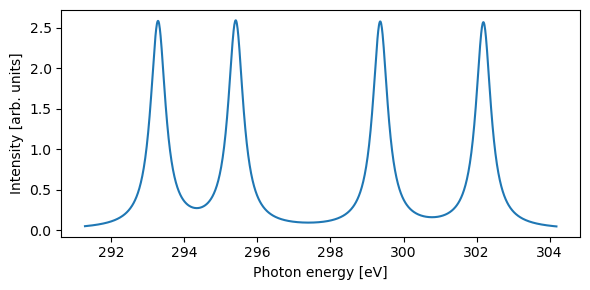

In [14]:
# IEs from above calculation
esca_ies = [302.187, 299.362, 295.405, 293.277]

# Broaden with a Lorentzian and plot
plt.figure(figsize=(6, 3))
x, y = esca_ies, np.ones((len(esca_ies)))
# Lorentzian function takes energies, intensities, energy range, step-size, and a broadening parameter
xi, yi = lorentzian(x, y, min(x) - 2, max(x) + 2, 0.01, 0.5)
plt.plot(xi, yi)
plt.xlabel("Photon energy [eV]")
plt.ylabel("Intensity [arb. units]")
plt.tight_layout()
plt.show()

In [15]:
water_mol_str = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Construct structure and basis objects
struct = gator.get_molecule(water_mol_str)
basis = gator.get_molecular_basis(struct, "6-31G")

# Perform SCF calculation
scf_results = scf_gs = gator.run_scf(struct, basis)

# Calculate the 6 lowest eigenstates with CVS restriction to MO #1 (oxygen 1s)
adc_result = gator.run_adc(
    struct, basis, scf_gs, method="cvs-adc2x", singlets=4, core_orbitals=1
)

* Info * Reading basis set from file: /Users/golo.dusanka/miniconda3/envs/echem/lib/python3.12/site-packages/veloxchem/basis/6-31G
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
        

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Starting Reduced Basis SCF calculation...                                                                        
* Info * ...done. SCF energy in reduced basis set: -75.983870205311 a.u. Time: 0.05 sec.                                  
                                                                                                                          


* Info * Overlap matrix computed in 0.00 sec.                                                                             
                                                                                                                          
* Info * Kinetic energy matrix computed in 0.00 sec.                                                                      
                                                                                                                          
* Info * Nuclear potential matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


                                                                                                                          
               Iter. | Hartree-Fock Energy | Energy Change | Gradient Norm | Max. Gradient | Density Change               
               --------------------------------------------------------------------------------------------               
                  1       -75.983870373952    0.0000000000      0.00006826      0.00001638      0.00000000                


                  2       -75.983870375702   -0.0000000017      0.00002636      0.00000475      0.00006304                


                  3       -75.983870375765   -0.0000000001      0.00000396      0.00000061      0.00000524                


                  4       -75.983870375769   -0.0000000000      0.00000029      0.00000008      0.00000296                


                                                                                                                          
               *** SCF converged in 4 iterations. Time: 0.05 sec.                                                         
                                                                                                                          


               Spin-Restricted Hartree-Fock:                                                                              
               -----------------------------                                                                              
               Total Energy                       :      -75.9838703758 a.u.                                              
               Electronic Energy                  :      -85.1400150952 a.u.                                              
               Nuclear Repulsion Energy           :        9.1561447194 a.u.                                              
               ------------------------------------                                                                       
               Gradient Norm                      :        0.0000002874 a.u.                                              
                                                                                                                          
                

                                                                                                                          
                                                Ground State Dipole Moment                                                
                                               ----------------------------                                               
                                                                                                                          
                                   X   :        -0.000000 a.u.        -0.000000 Debye                                     
                                   Y   :         0.000000 a.u.         0.000000 Debye                                     
                                   Z   :        -1.036166 a.u.        -2.633670 Debye                                     
                                 Total :         1.036166 a.u.         2.633670 Debye                                     
                

SCF converged in 4 iterations.
Total Energy: -75.9838703758 au


Starting cvs-adc2x singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values


  1     8        1.2621  166ms  [20.27035896 20.30081829 20.86977777 20.91121528]


  2    16      0.038976  250ms  [19.72495586 19.80691963 20.50881    20.51569984]


  3    24     0.0035541  297ms  [19.71673642 19.79707758 20.49577433 20.5050343 ]


  4    32    0.00029894  392ms  [19.71639059 19.79671156 20.49373717 20.50484016]


  5    40    3.1991e-05  412ms  [19.7163757  19.79669977 20.49353402 20.5048266 ]
=== Restart ===


  6    16    5.9779e-06  350ms  [19.7163752  19.79669907 20.49351316 20.50482466]


  7    24    1.1003e-06  290ms  [19.71637516 19.79669898 20.49350798 20.50482383]


  8    32    5.7208e-07  342ms  [19.71637516 19.79669897 20.49350754 20.50482373]
=== Converged ===
    Number of matrix applies:    64
    Total solver time:             2s 523ms


+--------------------------------------------------------------+
| cvs-adc2x                               singlet ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      19.71638      536.5099   0.0178       0.8       0.2  |
|  1       19.7967      538.6956   0.0373    0.8087    0.1913  |
|  2      20.49351      557.6567   0.0099    0.7858    0.2142  |
|  3      20.50482      557.9647   0.1016    0.8441    0.1559  |
+--------------------------------------------------------------+



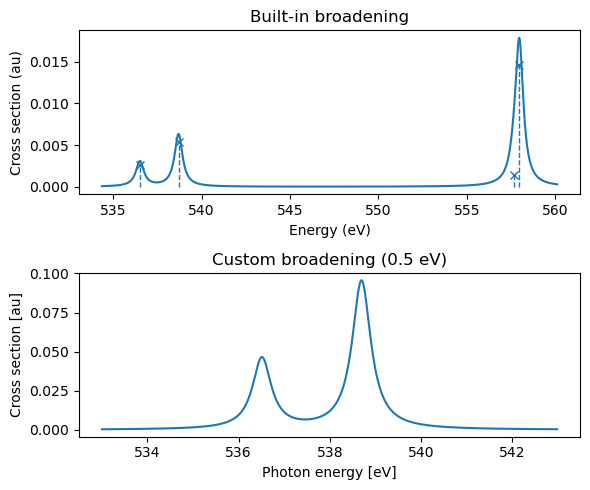

In [16]:
# Print information on eigenstates
print(adc_result.describe())

plt.figure(figsize=(6, 5))
# Convolute using functionalities available in gator and adcc
plt.subplot(211)
plt.title("Built-in broadening")
adc_result.plot_spectrum()

# Manually convoluted using excitation energies and oscillator strengths
plt.subplot(212)
plt.title("Custom broadening (0.5 eV)")
x, y = au2ev * adc_result.excitation_energy, adc_result.oscillator_strength
xi, yi = lorentzian(x, y, 533, 543, 0.01, 0.5)
plt.plot(xi, yi)
plt.xlabel("Photon energy [eV]")
plt.ylabel("Cross section [au]")
plt.tight_layout()
plt.show()

In [17]:
# Prepare molecule and basis objects
molecule = vlx.Molecule.read_xyz_string(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

scf_drv = vlx.ScfRestrictedDriver()
scf_drv.xcfun = "b3lyp"
scf_drv.grid_level = 4
scf_result = scf_drv.compute(molecule, basis)

rpa_drv = vlx.LinearResponseEigenSolver()
rpa_drv.core_excitation = True
rpa_drv.num_core_orbitals = 1
rpa_drv.update_settings({"nstates": 6}, method_settings)
rpa_result = rpa_drv.compute(molecule, basis, scf_result)

tda_drv = vlx.TdaEigenSolver()
tda_drv.core_excitation = True
tda_drv.num_core_orbitals = 1
tda_drv.update_settings({"nstates": 6}, method_settings)
tda_result = tda_drv.compute(molecule, basis, scf_result)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Kohn-Sham                                            
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

* Info * Molecular grid with 40792 points generated in 0.03 sec.                                                          
                                                                                                                          
* Info * Overlap matrix computed in 0.00 sec.                                                                             
                                                                                                                          
* Info * Kinetic energy matrix computed in 0.00 sec.                                                                      
                                                                                                                          
* Info * Nuclear potential matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Starting Reduced Basis SCF calculation...                                                                        
* Info * ...done. SCF energy in reduced basis set: -75.983870205310 a.u. Time: 0.04 sec.                                  
                                                                                                                          


* Info * Overlap matrix computed in 0.00 sec.                                                                             
                                                                                                                          
* Info * Kinetic energy matrix computed in 0.00 sec.                                                                      
                                                                                                                          
* Info * Nuclear potential matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


                                                                                                                          
               Iter. |    Kohn-Sham Energy | Energy Change | Gradient Norm | Max. Gradient | Density Change               
               --------------------------------------------------------------------------------------------               
                  1       -76.384872592259    0.0000000000      0.05814060      0.01079184      0.00000000                


                  2       -76.384686594376    0.0001859979      0.07420221      0.01375784      0.03127402                


                  3       -76.385180742153   -0.0004941478      0.00038519      0.00008834      0.01650959                


                  4       -76.385180774173   -0.0000000320      0.00007657      0.00002027      0.00029092                


                  5       -76.385180774932   -0.0000000008      0.00000194      0.00000051      0.00002929                


                  6       -76.385180774934   -0.0000000000      0.00000014      0.00000003      0.00000214                


                                                                                                                          
               *** SCF converged in 6 iterations. Time: 0.18 sec.                                                         
                                                                                                                          


               Spin-Restricted Kohn-Sham:                                                                                 
               --------------------------                                                                                 
               Total Energy                       :      -76.3851807749 a.u.                                              
               Electronic Energy                  :      -85.5413254944 a.u.                                              
               Nuclear Repulsion Energy           :        9.1561447194 a.u.                                              
               ------------------------------------                                                                       
               Gradient Norm                      :        0.0000001389 a.u.                                              
                                                                                                                          
                

                                                                                                                          
                                                Ground State Dipole Moment                                                
                                               ----------------------------                                               
                                                                                                                          
                                   X   :        -0.000000 a.u.        -0.000000 Debye                                     
                                   Y   :        -0.000000 a.u.        -0.000000 Debye                                     
                                   Z   :        -0.968145 a.u.        -2.460780 Debye                                     
                                 Total :         0.968145 a.u.         2.460780 Debye                                     
                

                                                                                                                          
                                            Linear Response EigenSolver Setup                                             
                                                                                                                          
                               Number of States                : 6                                                        
                               Max. Number of Iterations       : 150                                                      
                               Convergence Threshold           : 1.0e-04                                                  
                               ERI Screening Threshold         : 1.0e-12                                                  
                               Exchange-Correlation Functional : B3LYP                                                    
                

* Info * Using the B3LYP functional.                                                                                      
                                                                                                                          
         P. J. Stephens, F. J. Devlin, C. F. Chabalowski, and M. J. Frisch.,  J. Phys. Chem. 98, 11623 (1994)
                                                                                                                          
* Info * Using the Libxc library (v7.0.0).                                                                                
                                                                                                                          
         S. Lehtola, C. Steigemann, M. J.T. Oliveira, and M. A.L. Marques.,  SoftwareX 7, 1–5 (2018)
                                                                                                                          
* Info * Using the following algorithm for XC numer

* Info * Molecular grid with 40792 points generated in 0.03 sec.                                                          
                                                                                                                          
* Info * Processing 6 Fock builds...                                                                                      


                                                                                                                          
* Info * 6 gerade trial vectors in reduced space                                                                          
* Info * 6 ungerade trial vectors in reduced space                                                                        
                                                                                                                          
* Info * 3.24 kB of memory used for subspace procedure on the master node                                                 
* Info * 2.49 GB of memory available for the solver on the master node                                                    
                                                                                                                          
               *** Iteration:   1 * Residuals (Max,Min): 9.20e-02 and 6.06e-14                                            
                

* Info * Processing 2 Fock builds...                                                                                      


                                                                                                                          
* Info * 8 gerade trial vectors in reduced space                                                                          
* Info * 8 ungerade trial vectors in reduced space                                                                        
                                                                                                                          
* Info * 3.72 kB of memory used for subspace procedure on the master node                                                 
* Info * 2.49 GB of memory available for the solver on the master node                                                    
                                                                                                                          
               *** Iteration:   2 * Residuals (Max,Min): 8.91e-14 and 1.13e-14                                            
                

               *** Linear response converged in 2 iterations. Time: 0.22 sec                                              
                                                                                                                          
                                                                                                                          


               Electric Transition Dipole Moments (dipole length, a.u.)                                                   
               --------------------------------------------------------                                                   
                                                X            Y            Z                                               
               Excited State    S1:     -0.000000    -0.000000     0.036994                                               
               Excited State    S2:      0.053332    -0.000000     0.000000                                               
               Excited State    S3:     -0.026326     0.000000     0.000000                                               
               Excited State    S4:     -0.000000     0.000000    -0.085469                                               
               Excited State    S5:     -0.000000    -0.093173    -0.000000                                               
               E

               Electric Transition Dipole Moments (dipole velocity, a.u.)                                                 
               ----------------------------------------------------------                                                 
                                                X            Y            Z                                               
               Excited State    S1:     -0.000000     0.000000     0.037908                                               
               Excited State    S2:      0.054574    -0.000000     0.000000                                               
               Excited State    S3:     -0.023365     0.000000     0.000000                                               
               Excited State    S4:     -0.000000     0.000000    -0.082694                                               
               Excited State    S5:     -0.000000    -0.090596    -0.000000                                               
               E

               Magnetic Transition Dipole Moments (a.u.)                                                                  
               -----------------------------------------                                                                  
                                                X            Y            Z                                               
               Excited State    S1:     -0.000000    -0.000000     0.000000                                               
               Excited State    S2:      0.000000     0.116020    -0.000000                                               
               Excited State    S3:     -0.000000    -0.051026     0.000000                                               
               Excited State    S4:     -0.000000    -0.000000    -0.000000                                               
               Excited State    S5:      0.199855    -0.000000     0.000000                                               
               E

               One-Photon Absorption                                                                                      
               ---------------------                                                                                      
               Excited State    S1:     19.11231840 a.u.    520.07268 eV    Osc.Str.    0.0174                            
               Excited State    S2:     19.18487023 a.u.    522.04691 eV    Osc.Str.    0.0364                            
               Excited State    S3:     19.84589976 a.u.    540.03444 eV    Osc.Str.    0.0092                            
               Excited State    S4:     19.88247322 a.u.    541.02966 eV    Osc.Str.    0.0968                            
               Excited State    S5:     19.88970461 a.u.    541.22643 eV    Osc.Str.    0.1151                            
               Excited State    S6:     19.99474152 a.u.    544.08463 eV    Osc.Str.    0.0175                            
                

               Electronic Circular Dichroism                                                                              
               -----------------------------                                                                              
               Excited State    S1:     Rot.Str.     -0.000000 a.u.    -0.0000 [10**(-40) cgs]                            
               Excited State    S2:     Rot.Str.      0.000000 a.u.     0.0000 [10**(-40) cgs]                            
               Excited State    S3:     Rot.Str.      0.000000 a.u.     0.0000 [10**(-40) cgs]                            
               Excited State    S4:     Rot.Str.      0.000000 a.u.     0.0000 [10**(-40) cgs]                            
               Excited State    S5:     Rot.Str.     -0.000000 a.u.    -0.0000 [10**(-40) cgs]                            
               Excited State    S6:     Rot.Str.      0.000000 a.u.     0.0000 [10**(-40) cgs]                            
                

               Character of excitations:                                                                                  
                                                                                                                          
               Excited state 1                                                                                            
               ---------------                                                                                            
               core_1   -> LUMO        -0.9993                                                                            
                                                                                                                          
               Excited state 2                                                                                            
               ---------------                                                                                            
               c

                                                                                                                          
                                                     TDA Driver Setup                                                     
                                                                                                                          
                               Number of States                : 6                                                        
                               Max. Number of Iterations       : 150                                                      
                               Convergence Threshold           : 1.0e-04                                                  
                               ERI Screening Threshold         : 1.0e-12                                                  
                               Exchange-Correlation Functional : B3LYP                                                    
                

* Info * Using the B3LYP functional.                                                                                      
                                                                                                                          
         P. J. Stephens, F. J. Devlin, C. F. Chabalowski, and M. J. Frisch.,  J. Phys. Chem. 98, 11623 (1994)
                                                                                                                          
* Info * Using the Libxc library (v7.0.0).                                                                                
                                                                                                                          
         S. Lehtola, C. Steigemann, M. J.T. Oliveira, and M. A.L. Marques.,  SoftwareX 7, 1–5 (2018)
                                                                                                                          
* Info * Using the following algorithm for XC numer

* Info * Molecular grid with 40792 points generated in 0.03 sec.                                                          
                                                                                                                          
                   *** Iteration:   1 * Reduced Space:    6 * Residues (Max,Min): 3.75e-02 and 1.64e-14                   
                                                                                                                          
                   State  1: 19.11237694 a.u. Residual Norm: 0.00290066                                                   
                   State  2: 19.18648226 a.u. Residual Norm: 0.03751325                                                   
                   State  3: 19.84617005 a.u. Residual Norm: 0.00779844                                                   
                   State  4: 19.88255040 a.u. Residual Norm: 0.00222807                                                   
                

                   *** Iteration:   2 * Reduced Space:    8 * Residues (Max,Min): 1.56e-14 and 5.46e-16                   


                                                                                                                          
                   State  1: 19.11237075 a.u. Residual Norm: 0.00000000                                                   
                   State  2: 19.18489827 a.u. Residual Norm: 0.00000000                                                   
                   State  3: 19.84590521 a.u. Residual Norm: 0.00000000                                                   
                   State  4: 19.88254196 a.u. Residual Norm: 0.00000000                                                   
                   State  5: 19.88977342 a.u. Residual Norm: 0.00000000                                                   
                   State  6: 19.99479899 a.u. Residual Norm: 0.00000000                                                   
                                                                                                                          


               *** 6 excited states converged in 2 iterations. Time: 0.19 sec                                             
                                                                                                                          
                                                                                                                          


               Electric Transition Dipole Moments (dipole length, a.u.)                                                   
               --------------------------------------------------------                                                   
                                                X            Y            Z                                               
               Excited State    S1:      0.000000     0.000000    -0.037061                                               
               Excited State    S2:     -0.053417     0.000000    -0.000000                                               
               Excited State    S3:     -0.026359    -0.000000     0.000000                                               
               Excited State    S4:     -0.000000     0.000000    -0.085598                                               
               Excited State    S5:     -0.000000     0.093296     0.000000                                               
               E

               Electric Transition Dipole Moments (dipole velocity, a.u.)                                                 
               ----------------------------------------------------------                                                 
                                                X            Y            Z                                               
               Excited State    S1:      0.000000     0.000000    -0.037833                                               
               Excited State    S2:     -0.054477     0.000000    -0.000000                                               
               Excited State    S3:     -0.023319    -0.000000     0.000000                                               
               Excited State    S4:     -0.000000     0.000000    -0.082562                                               
               Excited State    S5:     -0.000000     0.090477     0.000000                                               
               E

               Magnetic Transition Dipole Moments (a.u.)                                                                  
               -----------------------------------------                                                                  
                                                X            Y            Z                                               
               Excited State    S1:     -0.000000     0.000000    -0.000000                                               
               Excited State    S2:     -0.000000    -0.115814     0.000000                                               
               Excited State    S3:      0.000000    -0.050925     0.000000                                               
               Excited State    S4:     -0.000000    -0.000000    -0.000000                                               
               Excited State    S5:     -0.199592    -0.000000    -0.000000                                               
               E

               One-Photon Absorption                                                                                      
               ---------------------                                                                                      
               Excited State    S1:     19.11237075 a.u.    520.07410 eV    Osc.Str.    0.0175                            
               Excited State    S2:     19.18489827 a.u.    522.04768 eV    Osc.Str.    0.0365                            
               Excited State    S3:     19.84590521 a.u.    540.03459 eV    Osc.Str.    0.0092                            
               Excited State    S4:     19.88254196 a.u.    541.03153 eV    Osc.Str.    0.0971                            
               Excited State    S5:     19.88977342 a.u.    541.22831 eV    Osc.Str.    0.1154                            
               Excited State    S6:     19.99479899 a.u.    544.08620 eV    Osc.Str.    0.0175                            
                

               Electronic Circular Dichroism                                                                              
               -----------------------------                                                                              
               Excited State    S1:     Rot.Str.     -0.000000 a.u.    -0.0000 [10**(-40) cgs]                            
               Excited State    S2:     Rot.Str.      0.000000 a.u.     0.0000 [10**(-40) cgs]                            
               Excited State    S3:     Rot.Str.     -0.000000 a.u.    -0.0000 [10**(-40) cgs]                            
               Excited State    S4:     Rot.Str.      0.000000 a.u.     0.0000 [10**(-40) cgs]                            
               Excited State    S5:     Rot.Str.      0.000000 a.u.     0.0000 [10**(-40) cgs]                            
               Excited State    S6:     Rot.Str.     -0.000000 a.u.    -0.0000 [10**(-40) cgs]                            
                

               Character of excitations:                                                                                  
                                                                                                                          
               Excited state 1                                                                                            
               ---------------                                                                                            
               core_1   -> LUMO         0.9993                                                                            
                                                                                                                          
               Excited state 2                                                                                            
               ---------------                                                                                            
               c

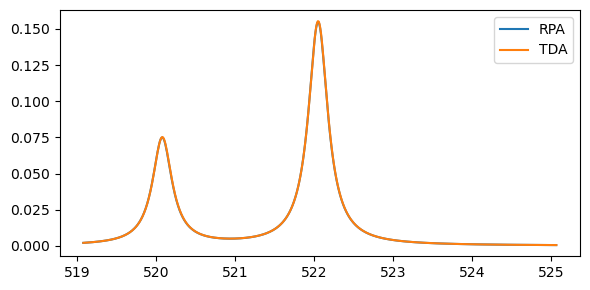

In [18]:
plt.figure(figsize=(6, 3))
# RPA results
x = 27.2114*rpa_result['eigenvalues']
y = rpa_result['oscillator_strengths']
xi,yi = lorentzian(x,y,min(x)-1,min(x)+5,0.01,0.3)
plt.plot(xi,yi)
# TDA results
x = 27.2114*tda_result['eigenvalues']
y = tda_result['oscillator_strengths']
xi,yi = lorentzian(x,y,min(x)-1,min(x)+5,0.01,0.3)
plt.plot(xi,yi)
plt.legend(('RPA','TDA'))
plt.tight_layout()
plt.show()

In [19]:
# Prepare molecule and basis objects
molecule = vlx.Molecule.read_xyz_string(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

# SCF settings and SCF optimization
scf_drv = vlx.ScfRestrictedDriver()
scf_settings = {"conv_thresh": 1.0e-6}
method_settings = {"xcfun": "b3lyp"}
scf_drv.update_settings(scf_settings, method_settings)
scf_result = scf_drv.compute(molecule, basis)

# Define spectrum region to be resolved
freqs = np.arange(515.0, 525.0, 0.1) / au2ev
freqs_str = [str(x) for x in freqs]

# Calculate the response
cpp_drv = vlx.rsplinabscross.LinearAbsorptionCrossSection(
    {"frequencies": ",".join(freqs_str), "damping": 0.3 / au2ev}, method_settings
)
cpp_drv.init_driver()
cpp_result = cpp_drv.compute(molecule, basis, scf_result)

# Extract the imaginary part of the complex response function and convert to absorption cross section
sigma = []
for w in freqs:
    axx = -cpp_drv.rsp_property["response_functions"][("x", "x", w)].imag
    ayy = -cpp_drv.rsp_property["response_functions"][("y", "y", w)].imag
    azz = -cpp_drv.rsp_property["response_functions"][("z", "z", w)].imag
    alpha_bar = (axx + ayy + azz) / 3.0
    sigma.append(4.0 * np.pi * w * alpha_bar / 137.035999)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Kohn-Sham                                            
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

* Info * Molecular grid with 40792 points generated in 0.03 sec.                                                          
                                                                                                                          
* Info * Overlap matrix computed in 0.00 sec.                                                                             
                                                                                                                          
* Info * Kinetic energy matrix computed in 0.00 sec.                                                                      
                                                                                                                          
* Info * Nuclear potential matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Starting Reduced Basis SCF calculation...                                                                        
* Info * ...done. SCF energy in reduced basis set: -75.983870205310 a.u. Time: 0.04 sec.                                  
                                                                                                                          


* Info * Overlap matrix computed in 0.00 sec.                                                                             
                                                                                                                          
* Info * Kinetic energy matrix computed in 0.00 sec.                                                                      
                                                                                                                          
* Info * Nuclear potential matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


                                                                                                                          
               Iter. |    Kohn-Sham Energy | Energy Change | Gradient Norm | Max. Gradient | Density Change               
               --------------------------------------------------------------------------------------------               
                  1       -76.384872592259    0.0000000000      0.05814060      0.01079184      0.00000000                


                  2       -76.384686594376    0.0001859979      0.07420221      0.01375784      0.03127402                


                  3       -76.385180742153   -0.0004941478      0.00038519      0.00008834      0.01650959                


                  4       -76.385180774173   -0.0000000320      0.00007657      0.00002027      0.00029092                


                  5       -76.385180774932   -0.0000000008      0.00000194      0.00000051      0.00002929                


                  6       -76.385180774934   -0.0000000000      0.00000014      0.00000003      0.00000214                


                                                                                                                          
               *** SCF converged in 6 iterations. Time: 0.19 sec.                                                         
                                                                                                                          


               Spin-Restricted Kohn-Sham:                                                                                 
               --------------------------                                                                                 
               Total Energy                       :      -76.3851807749 a.u.                                              
               Electronic Energy                  :      -85.5413254944 a.u.                                              
               Nuclear Repulsion Energy           :        9.1561447194 a.u.                                              
               ------------------------------------                                                                       
               Gradient Norm                      :        0.0000001389 a.u.                                              
                                                                                                                          
                

                                                                                                                          
                                                Ground State Dipole Moment                                                
                                               ----------------------------                                               
                                                                                                                          
                                   X   :         0.000000 a.u.         0.000000 Debye                                     
                                   Y   :        -0.000000 a.u.        -0.000000 Debye                                     
                                   Z   :        -0.968145 a.u.        -2.460780 Debye                                     
                                 Total :         0.968145 a.u.         2.460780 Debye                                     
                

                                              Complex Response Solver Setup                                               
                                                                                                                          
                               Number of Frequencies           : 100                                                      
                               Max. Number of Iterations       : 150                                                      
                               Convergence Threshold           : 1.0e-04                                                  
                               ERI Screening Threshold         : 1.0e-12                                                  
                               Exchange-Correlation Functional : B3LYP                                                    
                               Molecular Grid Level            : 4                                                        
                

* Info * Using the B3LYP functional.                                                                                      
                                                                                                                          
         P. J. Stephens, F. J. Devlin, C. F. Chabalowski, and M. J. Frisch.,  J. Phys. Chem. 98, 11623 (1994)
                                                                                                                          
* Info * Using the Libxc library (v7.0.0).                                                                                
                                                                                                                          
         S. Lehtola, C. Steigemann, M. J.T. Oliveira, and M. A.L. Marques.,  SoftwareX 7, 1–5 (2018)
                                                                                                                          
* Info * Using the following algorithm for XC numer

* Info * Molecular grid with 40792 points generated in 0.03 sec.                                                          
                                                                                                                          
* Info * Processing 9 Fock builds...                                                                                      


                                                                                                                          
* Info * 9 gerade trial vectors in reduced space                                                                          
* Info * 9 ungerade trial vectors in reduced space                                                                        
                                                                                                                          
* Info * 577.03 kB of memory used for subspace procedure on the master node                                               
* Info * 2.51 GB of memory available for the solver on the master node                                                    
                                                                                                                          
               *** Iteration:   1 * Residuals (Max,Min): 1.54e-01 and 5.63e-02                                            
                

* Info * Processing 8 Fock builds...                                                                                      


                                                                                                                          
* Info * 17 gerade trial vectors in reduced space                                                                         
* Info * 16 ungerade trial vectors in reduced space                                                                       
                                                                                                                          
* Info * 586.63 kB of memory used for subspace procedure on the master node                                               
* Info * 2.51 GB of memory available for the solver on the master node                                                    
                                                                                                                          
               *** Iteration:   2 * Residuals (Max,Min): 1.62e-02 and 5.24e-04                                            
                

* Info * Processing 7 Fock builds...                                                                                      


                                                                                                                          
* Info * 24 gerade trial vectors in reduced space                                                                         
* Info * 22 ungerade trial vectors in reduced space                                                                       
                                                                                                                          
* Info * 597.23 kB of memory used for subspace procedure on the master node                                               
* Info * 2.49 GB of memory available for the solver on the master node                                                    
                                                                                                                          
               *** Iteration:   3 * Residuals (Max,Min): 3.85e-04 and 3.07e-06                                            
                

* Info * Processing 2 Fock builds...                                                                                      


                                                                                                                          
* Info * 26 gerade trial vectors in reduced space                                                                         
* Info * 23 ungerade trial vectors in reduced space                                                                       
                                                                                                                          
* Info * 597.20 kB of memory used for subspace procedure on the master node                                               
* Info * 2.49 GB of memory available for the solver on the master node                                                    
                                                                                                                          
               *** Iteration:   4 * Residuals (Max,Min): 1.34e-04 and 3.07e-06                                            
                

* Info * Processing 1 Fock build...                                                                                       


                                                                                                                          
* Info * 27 gerade trial vectors in reduced space                                                                         
* Info * 24 ungerade trial vectors in reduced space                                                                       
                                                                                                                          
* Info * 598.15 kB of memory used for subspace procedure on the master node                                               
* Info * 2.49 GB of memory available for the solver on the master node                                                    
                                                                                                                          
               *** Iteration:   5 * Residuals (Max,Min): 9.94e-05 and 2.68e-06                                            
                

               *** Complex response converged in 5 iterations. Time: 1.99 sec                                             
                                                                                                                          
                                                                                                                          


               Response Functions at Given Frequencies                                                                    
                                                                                                                          
               Dipole  Dipole   Frequency            Real        Imaginary                                                
               -----------------------------------------------------------                                                
               <<  x  ;  x  >>    18.9259     -0.00650749     -0.00055710j                                                
               <<  x  ;  y  >>    18.9259     -0.00000000     -0.00000000j                                                
               <<  x  ;  z  >>    18.9259     -0.00000000     -0.00000000j                                                
               <<  y  ;  x  >>    18.9259     -0.00000000     -0.00000000j                                                
               <

               <<  x  ;  x  >>    19.1537     -0.07907513     -0.02891147j                                                
               <<  x  ;  y  >>    19.1537     -0.00000000     -0.00000000j                                                
               <<  x  ;  z  >>    19.1537     -0.00000000     -0.00000000j                                                
               <<  y  ;  x  >>    19.1537     -0.00000000     -0.00000000j                                                
               <<  y  ;  y  >>    19.1537     -0.00514408     -0.00018424j                                                
               <<  y  ;  z  >>    19.1537      0.00000000     -0.00000000j                                                
               <<  z  ;  x  >>    19.1537     -0.00000000     -0.00000000j                                                
               <<  z  ;  y  >>    19.1537     -0.00000000     -0.00000000j                                                
               <

               <<  y  ;  z  >>    19.1978      0.00000000      0.00000000j                                                
               <<  z  ;  x  >>    19.1978      0.00000000     -0.00000000j                                                
               <<  z  ;  y  >>    19.1978     -0.00000000     -0.00000000j                                                
               <<  z  ;  z  >>    19.1978      0.01131703     -0.00223792j                                                
                                                                                                                          
               Dipole  Dipole   Frequency            Real        Imaginary                                                
               -----------------------------------------------------------                                                
               <<  x  ;  x  >>    19.2015      0.12068381     -0.07909149j                                                
               <

               Linear Absorption Cross-Section                                                                            
                                                                                                                          
               Reference: J. Kauczor and P. Norman, J. Chem. Theory Comput. 2014, 10, 2449-2455.                          
                                                                                                                          
               Frequency[a.u.]     Frequency[eV]        sigma(w)[a.u.]                                                    
               -------------------------------------------------------                                                    
               18.9259             515.00000              0.00070163                                                      
               18.9296             515.10000              0.00072092                                                      
               1

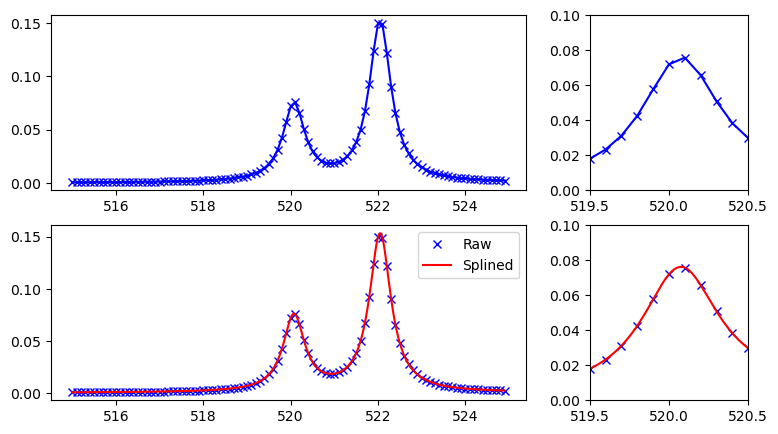

In [20]:
# Make figure with panels of 3:1 width
plt.figure(figsize=(9, 5))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1])

# Raw results for the full region
plt.subplot(gs[0])
plt.plot(au2ev * freqs, sigma, "bx-")

# Raw results for a zoomed-in region
plt.subplot(gs[1])
plt.plot(au2ev * freqs, sigma, "bx-")
plt.xlim((519.5, 520.5))
plt.ylim((0, 0.10))

# Raw and splined spectra for the full region
plt.subplot(gs[2])
plt.plot(au2ev * freqs, sigma, "bx")
x = np.arange(min(au2ev * freqs), max(au2ev * freqs), 0.01)
y = interp1d(au2ev * freqs, sigma, kind="cubic")
plt.plot(x, y(x), "r")
plt.legend(("Raw", "Splined"))

# Raw and splined spectra for a zoomed-in region
plt.subplot(gs[3])
plt.plot(au2ev * freqs, sigma, "bx")
plt.plot(x, y(x), "r")
plt.xlim((519.5, 520.5))
plt.ylim((0, 0.10))
plt.show()

In [21]:
# Create veloxchem mol and basis objects
molecule = vlx.Molecule.read_xyz_string(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-311G")

# Perform SCF calculation
scf_gs = vlx.ScfRestrictedDriver()
scf_result = scf_gs.compute(molecule, basis)

# Copy molecule object
mol_ion = copy.deepcopy(molecule)

# Change charge and multiplicity
mol_ion.set_charge(2)
mol_ion.set_multiplicity(1)

# Lists of occupied alpha and beta MOs
occa = [1, 2, 3, 4]
occb = [1, 2, 3, 4]

# Calculate SCF of core-ion
scf_ion = vlx.ScfRestrictedDriver()
scf_ion.maximum_overlap(mol_ion, basis, scf_gs.mol_orbs, occa, occb)
scf_ion_result = scf_ion.compute(mol_ion, basis)

# IE from energy difference
hf_ie = au2ev * (scf_ion.get_scf_energy() - scf_gs.get_scf_energy())

# Set up mock task for adcc
task = MockTask(mol_ion, basis, scf_ion.comm, scf_ion.ostream)
scf_ion.task = task

# Four lowest (negative) eigenstates
adc_xes = adcc.adc2(scf_ion, n_states=4)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Starting Reduced Basis SCF calculation...                                                                        
* Info * ...done. SCF energy in reduced basis set: -76.009200874912 a.u. Time: 0.07 sec.                                  
                                                                                                                          


* Info * Overlap matrix computed in 0.00 sec.                                                                             
                                                                                                                          
* Info * Kinetic energy matrix computed in 0.00 sec.                                                                      
                                                                                                                          
* Info * Nuclear potential matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


                                                                                                                          
               Iter. | Hartree-Fock Energy | Energy Change | Gradient Norm | Max. Gradient | Density Change               
               --------------------------------------------------------------------------------------------               
                  1       -76.009201256271    0.0000000000      0.00007050      0.00001299      0.00000000                


                  2       -76.009201258199   -0.0000000019      0.00001954      0.00000364      0.00004864                


                  3       -76.009201258238   -0.0000000000      0.00000469      0.00000077      0.00000463                


                  4       -76.009201258245   -0.0000000000      0.00000045      0.00000008      0.00000416                


                                                                                                                          
               *** SCF converged in 4 iterations. Time: 0.06 sec.                                                         
                                                                                                                          


               Spin-Restricted Hartree-Fock:                                                                              
               -----------------------------                                                                              
               Total Energy                       :      -76.0092012582 a.u.                                              
               Electronic Energy                  :      -85.1653459777 a.u.                                              
               Nuclear Repulsion Energy           :        9.1561447194 a.u.                                              
               ------------------------------------                                                                       
               Gradient Norm                      :        0.0000004459 a.u.                                              
                                                                                                                          
                

                                                                                                                          
                                                Ground State Dipole Moment                                                
                                               ----------------------------                                               
                                                                                                                          
                                   X   :        -0.000000 a.u.        -0.000000 Debye                                     
                                   Y   :        -0.000000 a.u.        -0.000000 Debye                                     
                                   Z   :        -1.034103 a.u.        -2.628427 Debye                                     
                                 Total :         1.034103 a.u.         2.628427 Debye                                     
                

                                                                                                                          
* Info * Checkpoint written to file: vlx_20251124_cecdb3d7_scf.h5                                                         
                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Restart from Checkpoint                                              
                   Convergence Accelerator         : Direct Inversion of Iterative Subspace                               
                

* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


                                                                                                                          
               Iter. | Hartree-Fock Energy | Energy Change | Gradient Norm | Max. Gradient | Density Change               
               --------------------------------------------------------------------------------------------               
                  1       -30.161332038996    0.0000000000      6.49842053      1.15847939      0.00000000                


                  2       -32.368782602399   -2.2074505634      3.48926148      0.47134945      1.19188987                


                  3       -32.921238395938   -0.5524557935      0.26430050      0.03965175      0.39725663                


                  4       -32.925064567664   -0.0038261717      0.01881446      0.00402002      0.03876945                


                  5       -32.925093423235   -0.0000288556      0.00307949      0.00059322      0.00374914                


                  6       -32.925094889309   -0.0000014661      0.00041602      0.00010740      0.00082677                


                  7       -32.925094919076   -0.0000000298      0.00004498      0.00000802      0.00011703                


                  8       -32.925094919391   -0.0000000003      0.00000635      0.00000109      0.00001460                


                  9       -32.925094919398   -0.0000000000      0.00000074      0.00000018      0.00000173                


                                                                                                                          
* Info * Checkpoint written to file: vlx_20251124_cecdb3d7_scf.h5                                                         
                                                                                                                          
               *** SCF converged in 9 iterations. Time: 0.11 sec.                                                         
                                                                                                                          


               Spin-Restricted Hartree-Fock:                                                                              
               -----------------------------                                                                              
               Total Energy                       :      -32.9250949194 a.u.                                              
               Electronic Energy                  :      -42.0812396388 a.u.                                              
               Nuclear Repulsion Energy           :        9.1561447194 a.u.                                              
               ------------------------------------                                                                       
               Gradient Norm                      :        0.0000007376 a.u.                                              
                                                                                                                          
                

                                                                                                                          
                                                Ground State Dipole Moment                                                
                                               ----------------------------                                               
                                 *** Warning: Molecule has non-zero charge. Dipole                                        
                                     moment will be dependent on the choice of origin.                                    
                                     Center of nuclear charge is chosen as the origin.                                    
                                                                                                                          
                                   X   :        -0.000000 a.u.        -0.000000 Debye                                     
                

Starting adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values


  1     8        2.2933  117ms

  [-21.96480492 -21.90563092 -21.73483303 -21.01654728]


  2    16         2.081  191ms  [-22.03269755 -21.97328748 -21.89692976 -21.83835335]


  3    24     0.0029265  225ms  [-22.20628771 -22.15928665 -22.09180476 -22.04620017]


  4    32    3.8499e-07  270ms  [-22.20631892 -22.15932552 -22.09183497 -22.04623561]
=== Converged ===
    Number of matrix applies:    32
    Total solver time:           824.873ms


+--------------------------------------------------------------+
| adc2                                        any ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0     -22.20632     -604.2647   0.0000    0.9644   0.03563  |
|  1     -22.15933      -602.986   0.0000    0.9622   0.03785  |
|  2     -22.09183     -601.1495   0.1612    0.9588   0.04123  |
|  3     -22.04624     -599.9086   0.1409    0.9561   0.04391  |
+--------------------------------------------------------------+



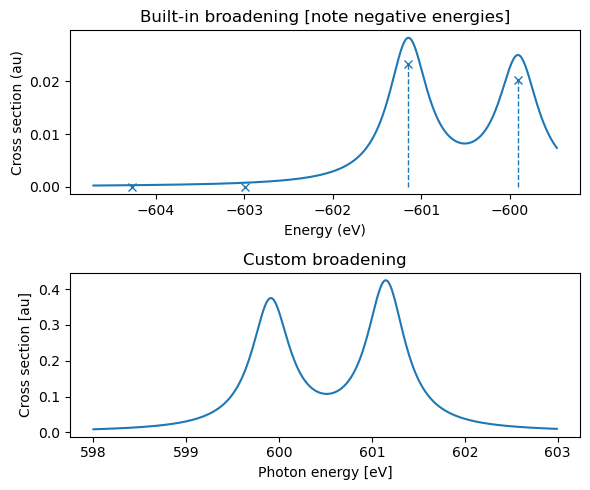

In [22]:
# Print information on eigenstates
print(adc_xes.describe())

plt.figure(figsize=(6, 5))
# Convolute using functionalities available in gator and adcc
plt.subplot(211)
plt.title("Built-in broadening [note negative energies]")
adc_xes.plot_spectrum()

# Convoluted using information on excitation energies and oscillator strengths
plt.subplot(212)
plt.title("Custom broadening")
x, y = -au2ev * adc_xes.excitation_energy, adc_xes.oscillator_strength
xi, yi = lorentzian(x, y, 598, 603, 0.01, 0.5)
plt.plot(xi, yi)
plt.xlabel("Photon energy [eV]")
plt.ylabel("Cross section [au]")
plt.tight_layout()
plt.show()

In [23]:
# Prepare molecule and basis objects
molecule = vlx.Molecule.read_xyz_string(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

# SCF settings and calculation
scf_drv = vlx.ScfRestrictedDriver()
scf_settings = {"conv_thresh": 1.0e-6}
method_settings = {"xcfun": "b3lyp"}
scf_drv.update_settings(scf_settings, method_settings)
scf_result = scf_drv.compute(molecule, basis)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Kohn-Sham                                            
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

* Info * Molecular grid with 40792 points generated in 0.03 sec.                                                          
                                                                                                                          
* Info * Overlap matrix computed in 0.00 sec.                                                                             
                                                                                                                          
* Info * Kinetic energy matrix computed in 0.00 sec.                                                                      
                                                                                                                          
* Info * Nuclear potential matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Starting Reduced Basis SCF calculation...                                                                        
* Info * ...done. SCF energy in reduced basis set: -75.983870205310 a.u. Time: 0.05 sec.                                  
                                                                                                                          


* Info * Overlap matrix computed in 0.00 sec.                                                                             
                                                                                                                          
* Info * Kinetic energy matrix computed in 0.00 sec.                                                                      
                                                                                                                          
* Info * Nuclear potential matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


                                                                                                                          
               Iter. |    Kohn-Sham Energy | Energy Change | Gradient Norm | Max. Gradient | Density Change               
               --------------------------------------------------------------------------------------------               
                  1       -76.384872592259    0.0000000000      0.05814060      0.01079184      0.00000000                


                  2       -76.384686594376    0.0001859979      0.07420221      0.01375784      0.03127402                


                  3       -76.385180742153   -0.0004941478      0.00038519      0.00008834      0.01650959                


                  4       -76.385180774173   -0.0000000320      0.00007657      0.00002027      0.00029092                


                  5       -76.385180774932   -0.0000000008      0.00000194      0.00000051      0.00002929                


                  6       -76.385180774934   -0.0000000000      0.00000014      0.00000003      0.00000214                


                                                                                                                          
               *** SCF converged in 6 iterations. Time: 0.18 sec.                                                         
                                                                                                                          


               Spin-Restricted Kohn-Sham:                                                                                 
               --------------------------                                                                                 
               Total Energy                       :      -76.3851807749 a.u.                                              
               Electronic Energy                  :      -85.5413254944 a.u.                                              
               Nuclear Repulsion Energy           :        9.1561447194 a.u.                                              
               ------------------------------------                                                                       
               Gradient Norm                      :        0.0000001389 a.u.                                              
                                                                                                                          
                

                                                                                                                          
                                                Ground State Dipole Moment                                                
                                               ----------------------------                                               
                                                                                                                          
                                   X   :        -0.000000 a.u.        -0.000000 Debye                                     
                                   Y   :         0.000000 a.u.         0.000000 Debye                                     
                                   Z   :        -0.968145 a.u.        -2.460780 Debye                                     
                                 Total :         0.968145 a.u.         2.460780 Debye                                     
                

In [24]:
# Extract orbital energies and number of occupied MOs
orbital_energies = scf_result["E_alpha"]
nocc = molecule.number_of_alpha_electrons()
print("Occupied MO energies:", au2ev * orbital_energies[:nocc])

# Define probed core MO and calculate energy differences
n_core = 0
energy_diff = []
for n_mo in np.arange(nocc):
    if n_mo != n_core:
        energy_diff.append(au2ev * (orbital_energies[n_mo] - orbital_energies[n_core]))

# Extract MO coefficients
mo_C = scf_result["C_alpha"]

# Load drivers for transition dipole moment
dipole_drv = vlx.ElectricDipoleIntegralsDriver()

# Calculated transition dipole moments and convert to MO basis
dipole_matrices = dipole_drv.compute(molecule, basis)
x_ao = dipole_matrices.x_to_numpy()
x_mo = np.matmul(mo_C.T, np.matmul(x_ao, mo_C))
y_ao = dipole_matrices.y_to_numpy()
y_mo = np.matmul(mo_C.T, np.matmul(y_ao, mo_C))
z_ao = dipole_matrices.z_to_numpy()
z_mo = np.matmul(mo_C.T, np.matmul(z_ao, mo_C))

# Construct oscillator strengths
xx, yy, zz, sigma = [], [], [], []
for n_mo in np.arange(nocc):
    if n_mo != n_core:
        x_tmp, y_tmp, z_tmp = x_mo[n_core, n_mo], y_mo[n_core, n_mo], z_mo[n_core, n_mo]
        xx.append(x_tmp)
        yy.append(y_tmp)
        zz.append(z_tmp)
        sigma.append(x_tmp ** 2 + y_tmp ** 2 + z_tmp ** 2)

Occupied MO energies: [-520.65707757  -27.6878829   -14.39950787   -9.70379307   -7.94953867]


Energy   Osc. str.   x-component   y-component   z-component
492.969   0.00022     -0.00000       0.00000      -0.01478
506.258   0.00238      0.04878       0.00000      -0.00000
510.953   0.00255     -0.00000       0.00000       0.05050
512.708   0.00342      0.00000      -0.05848       0.00000


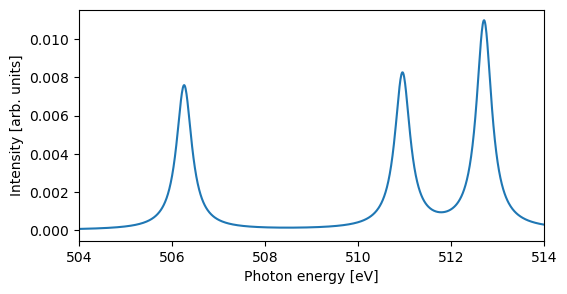

In [25]:
# Print results as a table
print("Energy   Osc. str.   x-component   y-component   z-component")
for i in np.arange(len(energy_diff)):
    e, os, x, y, z = energy_diff[i], sigma[i], xx[i], yy[i], zz[i]
    print(
        "{:.3f}  {:8.5f}     {:8.5f}      {:8.5f}      {:8.5f}".format(e, os, x, y, z)
    )

# Plot X-ray emission spectrum
plt.figure(figsize=(6, 3))
x, y = energy_diff, sigma
xi, yi = lorentzian(x, y, min(x) - 5, max(x) + 5, 0.01, 0.4)
plt.plot(xi, yi)
plt.xlabel("Photon energy [eV]")
plt.ylabel("Intensity [arb. units]")
plt.xlim((504, 514))
plt.show()